# Interpolation

The metocean datasets for velocity are on regular, uniform grids. We need to be able to estimate the velocity at sub-grid scale.  This notebooks explores making that estimate using interpolation.

[Wikipedia: Interpolation](https://en.wikipedia.org/wiki/Interpolation)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Interpolation_example_linear.svg/512px-Interpolation_example_linear.svg.png"/>

Since this is critical aspect of our project, this notebook explores difference approaches to interpolation and provides examples for related test cases.

## Scipy.interpolate

In [1]:
import scipy.interpolate as interp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Suppose we have the data:

In [2]:
x = np.array([0, 2, 4, 6, 8])
y = np.array([0, 1, 4, 9, 0])

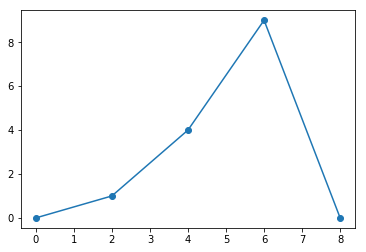

In [3]:
plt.plot(x, y, 'o-')

In [4]:
import numba

In [5]:
def get_interpolated_value(grid, data, point):
  
    while data.ndim > 0:
        x0, dx = grid[0]
        x_pt = point[0]
    
        x_idx = (x_pt - x0)/dx
        
        x_idx0 = int(np.floor(x_idx))
        dx_idx = (x_idx - x_idx0)
        
        A = data[x_idx0:x_idx0+2, ...]
        data = (1-dx_idx)*A[0,...] + (dx_idx)*A[1,...]
        grid = grid[1:]
        point = point[1:]
    
           
    return data

# 1-D test case


In [6]:
# We can interpolate using scipy.interpolate.interp1d

point = 6.5

f = interp.interp1d(x, y)
print(f(point))

# or RegularGridInterpolator
g = interp.RegularGridInterpolator( (x,), y)

#interp.RegularGridInterpolator
print(g( [[point,]] ) )

# our interpolator
grid = ((x[0], x[1]-x[0]), )
h = get_interpolated_value(grid, y, (point,))
print(h)

6.75
[6.75]
6.75


# 2D test case


In [7]:
x = np.linspace(0, 10, 6, endpoint=True)
y = np.linspace(0, 5, 6, endpoint=True)

X, Y = np.meshgrid(x, y)
Z = np.sin(X*Y)

In [8]:
def test_2d(x0, y0):
    point = (x0, y0)
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    plt.figure(figsize=(12,6))
    #plt.pcolormesh(X, Y, Z, cmap='viridis')
    plt.imshow(Z, extent=[x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2], 
           interpolation='nearest',
           origin='lower',)
    plt.colorbar()
    plt.scatter(X, Y)
    plt.scatter(*point, color='r', marker='x', s=150)


    f = interp.interp2d(x, y, Z)
    print(f(*point))

    # or RegularGridInterpolator
    g = interp.RegularGridInterpolator( (x,y), Z)
    #interp.RegularGridInterpolator
    print(g( [point,] ) )

    # our interpolator
    grid = ((x[0], dx), (y[0], dy) )
    h = get_interpolated_value(grid, Z, point)
    print(h)

In [9]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [10]:
interact( test_2d, x0=(0,10, 0.1), y0=(0,5, 0.1))

interactive(children=(FloatSlider(value=5.0, description='x0', max=10.0), FloatSlider(value=2.0, description='…

<function __main__.test_2d(x0, y0)>

# Test 3d

In [11]:
x = np.linspace(0, 10, 6, endpoint=True)
y = np.linspace(0, 5, 6, endpoint=True)
z = np.linspace(0, 20, 6, endpoint=True)
X, Y, Z = np.meshgrid(x, y, z)
Q = np.sin(X*Y*Z)

In [12]:
def test_3d(x0, y0, z0):
    point = (x0, y0, z0)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dz = z[1] - z[0]

    f = interp.interpn((x, y, z), Q, point)
    print(f)

    # or RegularGridInterpolator
    g = interp.RegularGridInterpolator( (x,y,z), Q)
    #interp.RegularGridInterpolator
    print(g( [point,] ) )

    # our interpolator
    grid = ((x[0], dx), (y[0], dy), (z[0], dz) )
    h = get_interpolated_value(grid, Q, point)
    print(h)

In [13]:
interact( test_3d, x0=(0,10, 0.1), y0=(0,5, 0.1), z0=(0,20,0.1))

interactive(children=(FloatSlider(value=5.0, description='x0', max=10.0), FloatSlider(value=2.0, description='…

<function __main__.test_3d(x0, y0, z0)>

# Now with ocean data!

In [14]:
from datetime import timedelta
import numpy as np

from icedef import metocean, test_case

import netCDF4 as nc
import pandas as pd

import numba

In [15]:
tc = test_case.TestCaseA()

In [16]:
ocean = metocean.Ocean(tc.time_frame)

In [17]:
ocean_times = ocean.data.time.values

In [18]:
ocean_timestamps = [pd.Timestamp(t) for t in ocean.data.time.values]
ocean_times = nc.date2num(ocean_timestamps, 'hours since 1950-01-01')
ocean_lats = ocean.data.latitude.values
ocean_lons = ocean.data.longitude.values

In [19]:
berg_time = nc.date2num(pd.Timestamp(tc.start_time), 'hours since 1950-01-01')
berg_lat = tc.start_latitude
berg_lon = tc.start_longitude

In [20]:
point = (berg_time, berg_lat, berg_lon)
dt = ocean_times[1] - ocean_times[0]
dlat = ocean_lats[1] - ocean_lats[0]
dlon = ocean_lons[1] - ocean_lons[0]
grid = ((ocean_times[0], dt), (ocean_lats[0], dlat), (ocean_lons[0], dlon))
data = ocean.current.eastward_velocities.values

In [21]:
@numba.jit
def get_interpolated_value(grid, data, point):
    while data.ndim > 0:
        x0, dx = grid[0]
        x_pt = point[0]
        x_idx = (x_pt - x0)/dx
        x_idx0 = int(np.floor(x_idx))
        dx_idx = (x_idx - x_idx0)
        A = data[x_idx0:x_idx0+2, ...]
        data = (1-dx_idx)*A[0,...] + (dx_idx)*A[1,...]
        grid = grid[1:]
        point = point[1:]    
    return data

In [22]:
@numba.jit
def get_interpolated_value2(grid, data, point):
    for dim in range(3):
        x0, dx = grid[0]
        x_pt = point[0]
        x_idx = (x_pt - x0)/dx
        x_idx0 = int(np.floor(x_idx))
        dx_idx = (x_idx - x_idx0)
        A = data[x_idx0:x_idx0+2, ...]
        data = (1-dx_idx)*A[0,...] + (dx_idx)*A[1,...]
        grid = grid[1:]
        point = point[1:]
    return data

In [23]:
print(get_interpolated_value2(grid, data, point))
%timeit get_interpolated_value2(grid, data, point)

0.06415714440343023
220 µs ± 203 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
g = interp.RegularGridInterpolator((ocean_times, ocean_lats, ocean_lons), data)
print(g([point,])[0])
%timeit g([point,])[0]

0.0641283876523373
606 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
print(interp.interpn((ocean_times, ocean_lats, ocean_lons), data, point)[0])
%timeit interp.interpn((ocean_times, ocean_lats, ocean_lons), data, point)[0]

0.0641283876523373
916 µs ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
